#Model Performance on The Data collected On TRS403 (one model for both types)

🔧 Training XGBoost (multi-output)...
✅ Model trained successfully.
Number of spectrum bins = 104


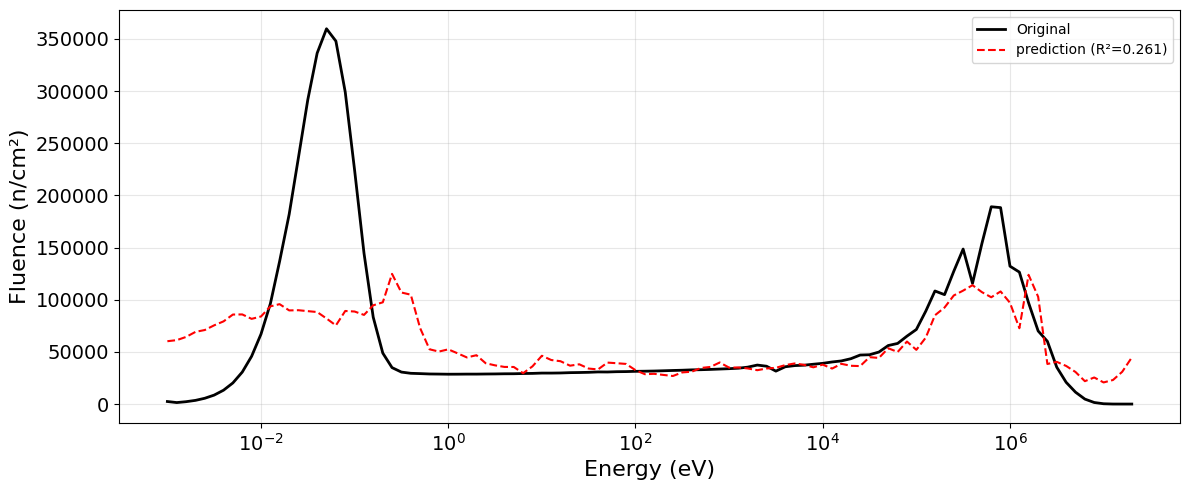

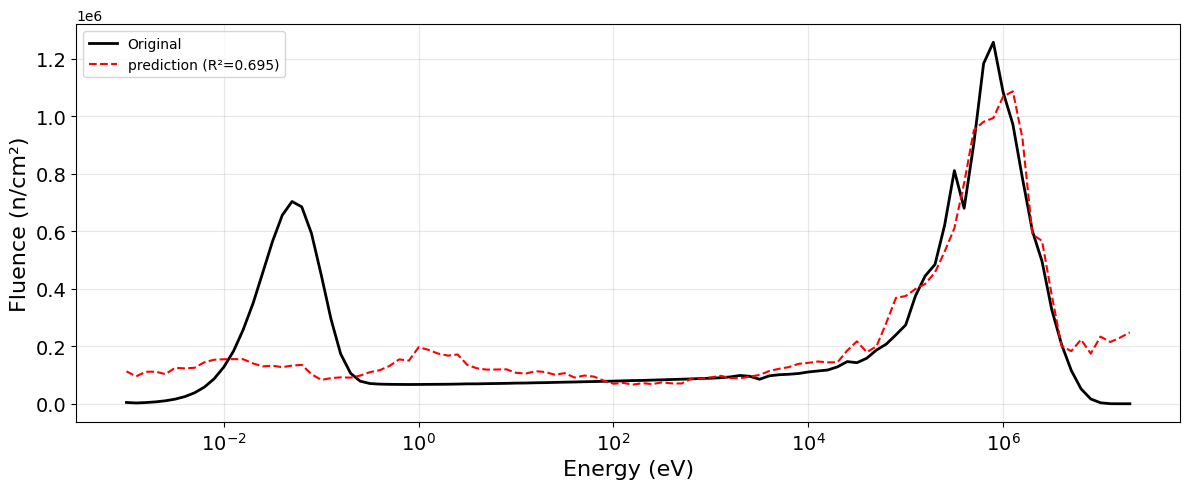

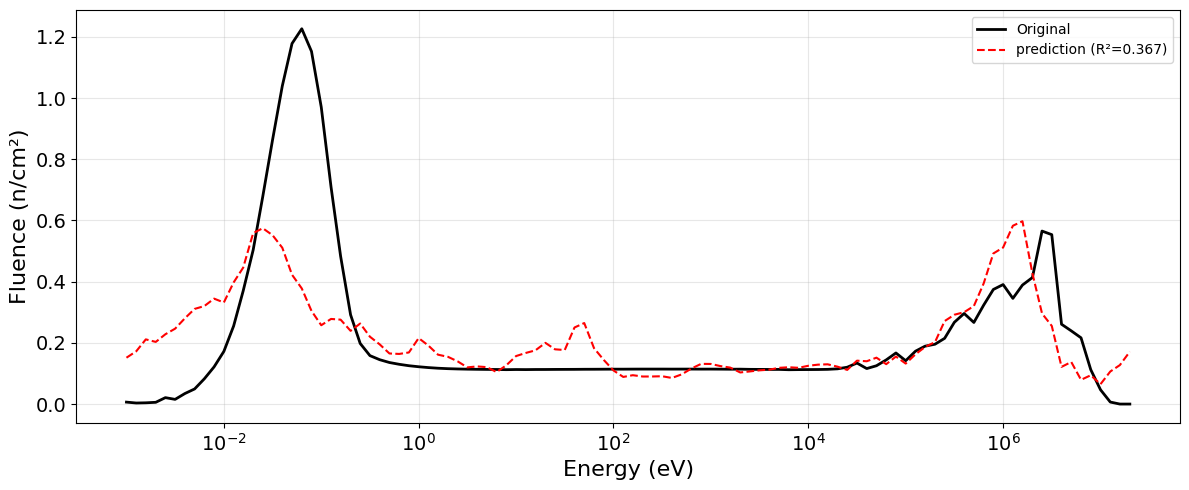

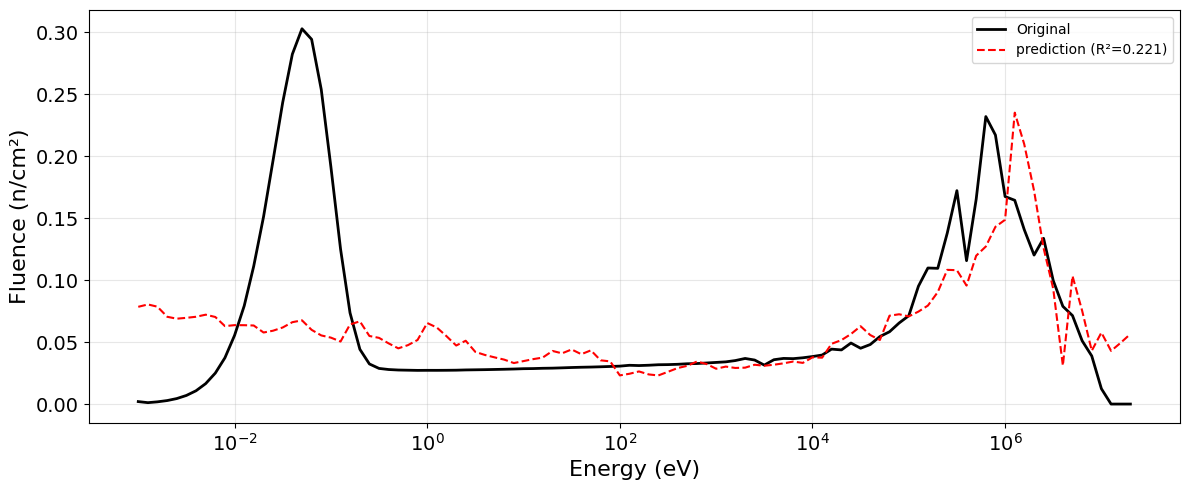

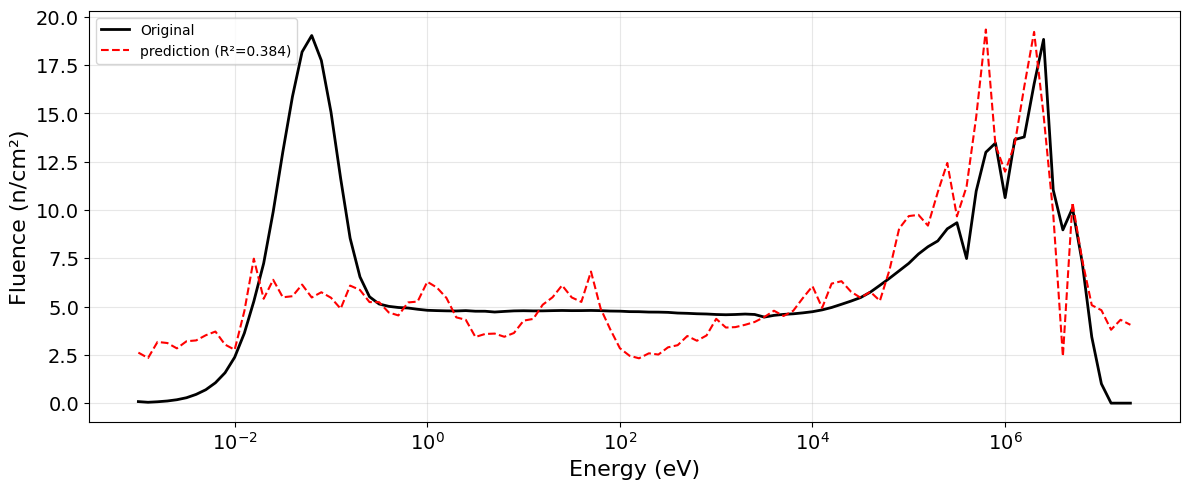

✅ Results saved to xgb_sums_results.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --------------------------
# 1) LOAD TRAINING DATA + NORMALIZE
# --------------------------
try:
    train_df = pd.read_csv("Dataset_modified.csv")
except FileNotFoundError:
    print("Error: 'complete_dataset.csv' not found. Please check the file path.")
    # Dummy training data
    num_samples_train = 100
    num_counts = 50
    num_spectrum = 104
    train_df = pd.DataFrame(np.random.rand(num_samples_train, num_counts + num_spectrum))
    train_df.columns = [f"count_{i}" for i in range(num_counts)] + [f"spectrum_value_{i}" for i in range(num_spectrum)]

spectrum_cols = [c for c in train_df.columns if c.startswith("spectrum_value_")]
count_cols = [c for c in train_df.columns if c.startswith("count_")]
train_df[spectrum_cols] = train_df[spectrum_cols].apply(pd.to_numeric, errors="coerce")

# Normalize counts and spectra
train_counts_total = train_df[count_cols].sum(axis=1)
train_counts_total[train_counts_total == 0] = 1
train_spectrum_total = train_df[spectrum_cols].sum(axis=1)
train_spectrum_total[train_spectrum_total == 0] = 1

train_df[count_cols] = train_df[count_cols].div(train_counts_total, axis=0)
train_df[spectrum_cols] = train_df[spectrum_cols].div(train_spectrum_total, axis=0)

X_train = train_df[count_cols].values
Y_train = train_df[spectrum_cols].values

# --------------------------
# 2) TRAIN XGBOOST MODELS (multi-output via loop)
# --------------------------
def train_xgb_multioutput(X, Y):
    models = []
    for j in range(Y.shape[1]):
        model = XGBRegressor(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            tree_method="hist",
            n_jobs=-1,
            verbosity=0,
            random_state=42
        )
        model.fit(X, Y[:, j])
        models.append(model)
    return models

def predict_xgb_multioutput(models, X):
    preds = [model.predict(X) for model in models]
    return np.column_stack(preds)

print("🔧 Training XGBoost (multi-output)...")
xgb_models = train_xgb_multioutput(X_train, Y_train)
print("✅ Model trained successfully.")

# --------------------------
# 3) LOAD TEST DATA + NORMALIZE
# --------------------------
try:
    test_df = pd.read_csv("Test_Dataset_modified.csv")
except FileNotFoundError:
    print("Error: 'Test_Dataset_modified.csv' not found. Please check the file path.")
    # Dummy test data
    num_samples_test = 10
    test_df = pd.DataFrame(np.random.rand(num_samples_test, num_counts + num_spectrum + 1))
    test_df.columns = ["spectrum_id"] + [f"count_{i}" for i in range(num_counts)] + [f"spectrum_value_{i}" for i in range(num_spectrum)]
    test_df["spectrum_id"] = [f"test_{i}" for i in range(num_samples_test)]

test_df[spectrum_cols] = test_df[spectrum_cols].apply(pd.to_numeric, errors="coerce")

test_counts_total = test_df[count_cols].sum(axis=1)
test_counts_total[test_counts_total == 0] = 1
test_spectrum_total = test_df[spectrum_cols].sum(axis=1)
test_spectrum_total[test_spectrum_total == 0] = 1

test_df[count_cols] = test_df[count_cols].div(test_counts_total, axis=0)
test_df[spectrum_cols] = test_df[spectrum_cols].div(test_spectrum_total, axis=0)

# --------------------------
# 4) ENERGY BINS
# --------------------------
bin_edges = np.array([
    0.001, 0.00126, 0.00158, 0.002, 0.00251, 0.00316, 0.00398, 0.00501, 0.00631, 0.00794,
    0.01, 0.0126, 0.0158, 0.02, 0.0251, 0.0316, 0.0398, 0.0501, 0.0631, 0.0794,
    0.1, 0.126, 0.158, 0.2, 0.251, 0.316, 0.398, 0.501, 0.631, 0.794,
    1, 1.26, 1.58, 2, 2.51, 3.16, 3.98, 5.01, 6.31, 7.94,
    10, 12.6, 15.8, 20, 25.1, 31.6, 39.8, 50.1, 63.1, 79.4,
    100, 126, 158, 200, 251, 316, 398, 501, 631, 794,
    1000, 1260, 1580, 2000, 2510, 3160, 3980, 5010, 6310, 7940,
    10000, 12600, 15800, 20000, 25100, 31600, 39800, 50100, 63100, 79400,
    100000, 126000, 158000, 200000, 251000, 316000, 398000, 501000, 631000, 794000,
    1000000, 1260000, 1580000, 2000000, 2510000, 3160000, 3980000, 5010000, 6310000, 7940000,
    10000000, 12600000, 15800000, 20000000
])

n_bins = len(bin_edges)
print(f"Number of spectrum bins = {n_bins}")

# Region masks
thermal_mask    = bin_edges < 0.4
epithermal_mask = (bin_edges >= 0.4) & (bin_edges < 1e5)
fast_mask       = bin_edges >= 1e5
total_mask      = np.ones(n_bins, dtype=bool)

region_masks = {
    "thermal": thermal_mask,
    "epithermal": epithermal_mask,
    "fast": fast_mask,
    "total": total_mask,
}

# --------------------------
# 5) PREDICT + EVALUATE
# --------------------------
results = []

for idx, row in test_df.iterrows():
    x_test = row[count_cols].values.reshape(1, -1)
    y_true_norm = row[spectrum_cols].values
    y_pred_norm = predict_xgb_multioutput(xgb_models, x_test)[0]

    # Restore actual values
    spectrum_total = test_spectrum_total.iloc[idx]
    y_true_actual = y_true_norm * spectrum_total
    y_pred_actual = y_pred_norm * spectrum_total

    mse = mean_squared_error(y_true_actual, y_pred_actual)
    r2 = r2_score(y_true_actual, y_pred_actual)

    row_res = {"spectrum_id": row["spectrum_id"], "MSE": mse, "R2": r2}
    for region, mask in region_masks.items():
        phi_true_sum = np.sum(y_true_actual[mask])
        phi_pred_sum = np.sum(y_pred_actual[mask])
        rel_diff_sum = 100 * (phi_pred_sum - phi_true_sum) / (phi_true_sum if phi_true_sum != 0 else 1)

        row_res[f"{region}_sum_true"] = phi_true_sum
        row_res[f"{region}_sum_pred"] = phi_pred_sum
        row_res[f"{region}_sum_reldiff(%)"] = rel_diff_sum

    results.append(row_res)

    # Plot spectrum comparison
    plt.figure(figsize=(12, 5))
    plt.semilogx(bin_edges, y_true_actual, label="Original", color="black", linewidth=2)
    plt.semilogx(bin_edges, y_pred_actual, linestyle="--",
                 label=f"prediction (R²={r2:.3f})", color="red")
    plt.xlabel("Energy (eV)", fontsize=16)
    plt.ylabel("Fluence (n/cm²)", fontsize=16)
    plt.legend()
    plt.grid(alpha=0.3, which="both")
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

# --------------------------
# 6) SAVE RESULTS
# --------------------------
results_df = pd.DataFrame(results)
results_df.to_csv("xgb_sums_results.csv", index=False)
print("✅ Results saved to xgb_sums_results.csv")


#Model Performance After Data Cleaning

🔧 Training XGBoost...
✅ XGBoost trained successfully.


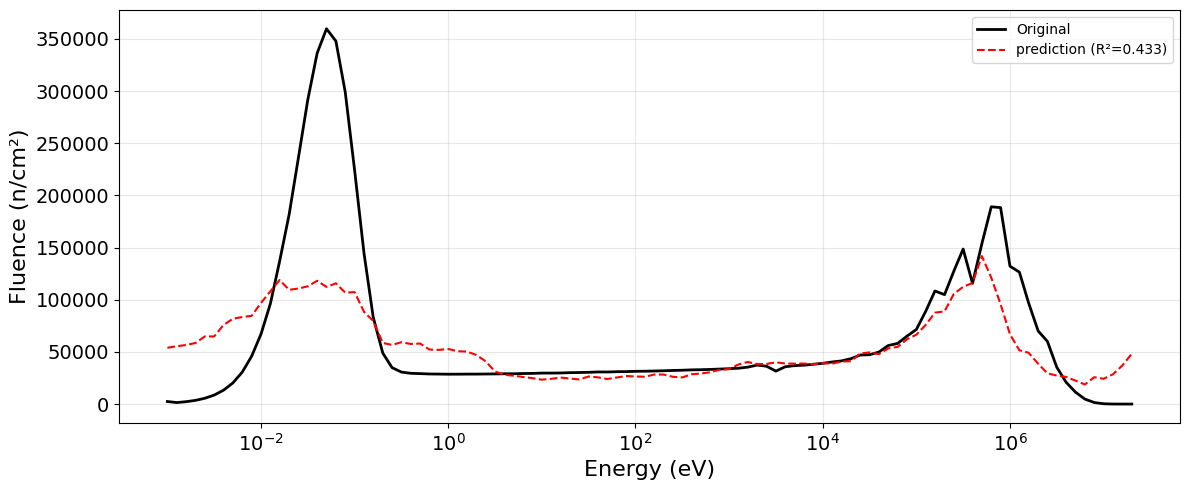

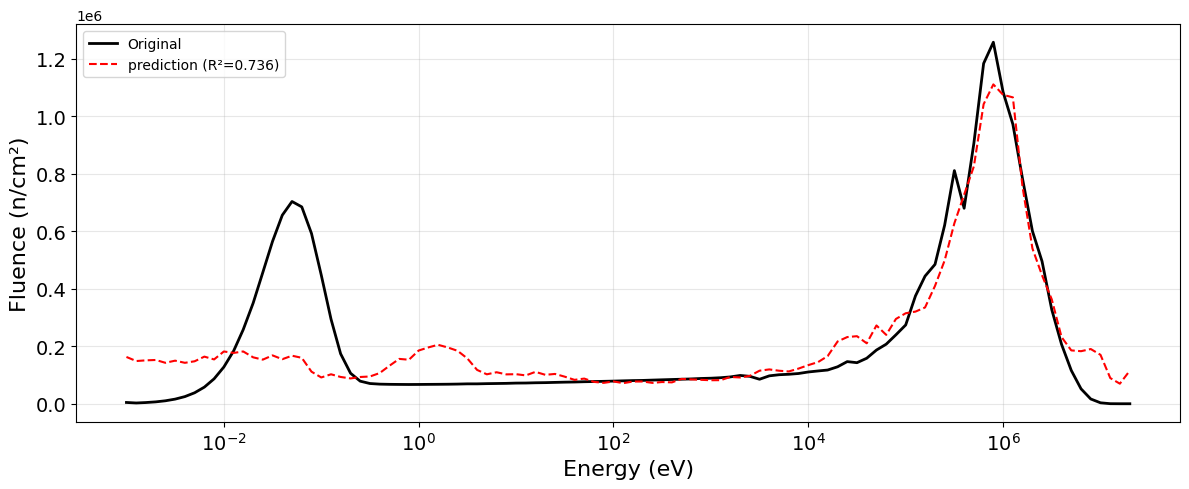

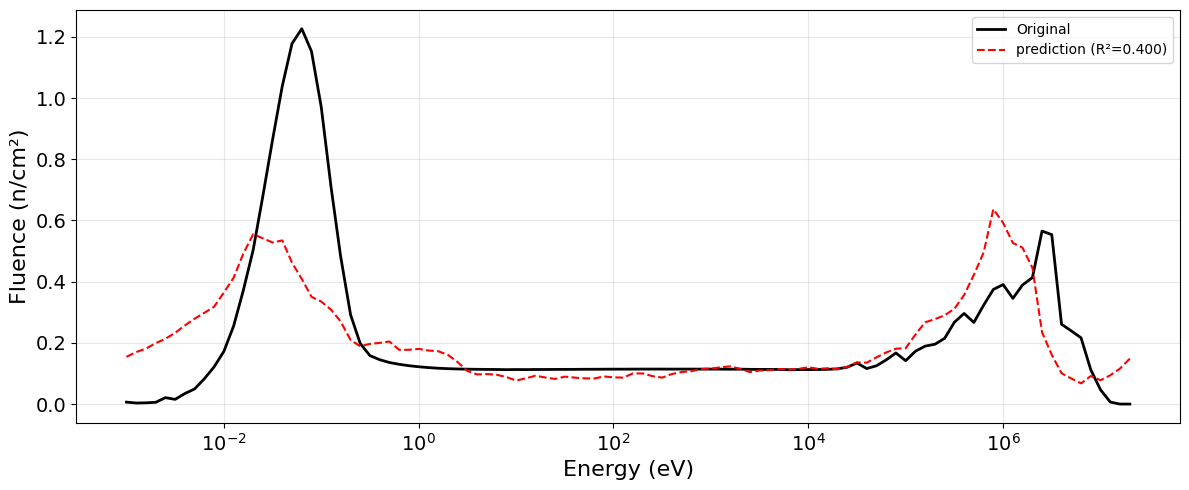

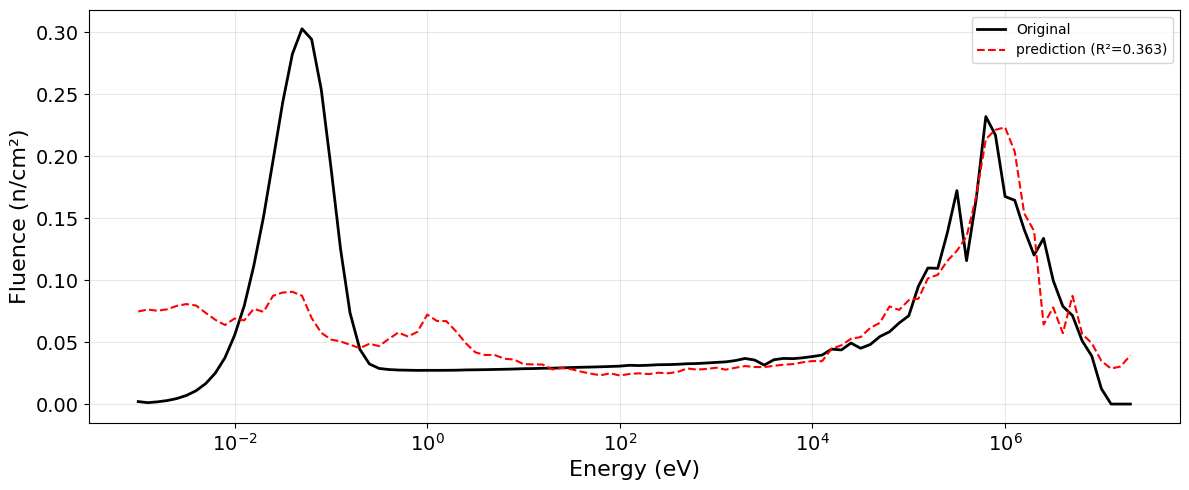

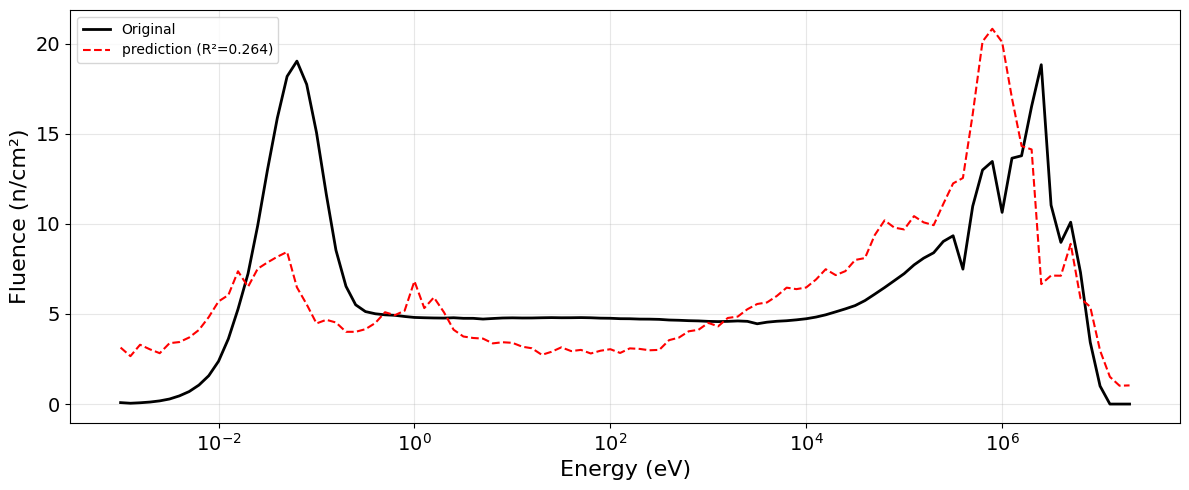

✅ Results saved to xgb_sums_results_filtered.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --------------------------
# 1) LOAD TRAINING DATA + REMOVE BAD IDS + NORMALIZE
# --------------------------
train_df = pd.read_csv("/content/Dataset_modified.csv")
spectrum_cols = [c for c in train_df.columns if c.startswith("spectrum_value_")]
count_cols = [c for c in train_df.columns if c.startswith("count_")]
train_df[spectrum_cols] = train_df[spectrum_cols].apply(pd.to_numeric, errors="coerce")

# ❌ Remove specific bad spectrum IDs
remove_ids = {5,6,7,8,13,14,15,16,17,18,19,20,21,22,23,24,
              48,49,51,52,53,54,55,56,57,58,
              68,70,74,75,77,78,79,81,82,
              86,89,90,91,92,96,97,98,99,100,
              102,106,107,108,110,111,112,113,114}
train_df = train_df[~train_df["spectrum_id"].isin(remove_ids)].copy()

# Normalization
train_counts_total = train_df[count_cols].sum(axis=1)
train_counts_total[train_counts_total == 0] = 1
train_spectrum_total = train_df[spectrum_cols].sum(axis=1)
train_spectrum_total[train_spectrum_total == 0] = 1

train_df[count_cols] = train_df[count_cols].div(train_counts_total, axis=0)
train_df[spectrum_cols] = train_df[spectrum_cols].div(train_spectrum_total, axis=0)

# ✅ Features = counts only
X_train = train_df[count_cols].values
Y_train = train_df[spectrum_cols].values

# --------------------------
# 2) TRAIN XGBOOST MODELS (multi-output)
# --------------------------
def train_xgb_multioutput(X, Y):
    models = []
    for j in range(Y.shape[1]):
        model = XGBRegressor(
            n_estimators=300, max_depth=6, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            tree_method="hist", n_jobs=-1, verbosity=0, random_state=42
        )
        model.fit(X, Y[:, j])
        models.append(model)
    return models

def predict_xgb_multioutput(models, X):
    preds = [model.predict(X) for model in models]
    return np.column_stack(preds)

print("🔧 Training XGBoost...")
xgb_models = train_xgb_multioutput(X_train, Y_train)
print("✅ XGBoost trained successfully.")

# --------------------------
# 3) LOAD TEST DATA + REMOVE BAD IDS + NORMALIZE
# --------------------------
test_df = pd.read_csv("/content/Test_Dataset_modified.csv")
test_df[spectrum_cols] = test_df[spectrum_cols].apply(pd.to_numeric, errors="coerce")

# ❌ Remove same bad IDs
test_df = test_df.copy()

test_counts_total = test_df[count_cols].sum(axis=1)
test_counts_total[test_counts_total == 0] = 1
test_spectrum_total = test_df[spectrum_cols].sum(axis=1)
test_spectrum_total[test_spectrum_total == 0] = 1

test_df[count_cols] = test_df[count_cols].div(test_counts_total, axis=0)
test_df[spectrum_cols] = test_df[spectrum_cols].div(test_spectrum_total, axis=0)

X_test_all = test_df[count_cols].values

# --------------------------
# 4) ENERGY BINS + REGION MASKS
# --------------------------
energy_bins = np.array([
    0.001, 0.00126, 0.00158, 0.002, 0.00251, 0.00316, 0.00398, 0.00501, 0.00631, 0.00794,
    0.01, 0.0126, 0.0158, 0.02, 0.0251, 0.0316, 0.0398, 0.0501, 0.0631, 0.0794,
    0.1, 0.126, 0.158, 0.2, 0.251, 0.316, 0.398, 0.501, 0.631, 0.794,
    1, 1.26, 1.58, 2, 2.51, 3.16, 3.98, 5.01, 6.31, 7.94,
    10, 12.6, 15.8, 20, 25.1, 31.6, 39.8, 50.1, 63.1, 79.4,
    100, 126, 158, 200, 251, 316, 398, 501, 631, 794,
    1000, 1260, 1580, 2000, 2510, 3160, 3980, 5010, 6310, 7940,
    10000, 12600, 15800, 20000, 25100, 31600, 39800, 50100, 63100, 79400,
    100000, 126000, 158000, 200000, 251000, 316000, 398000, 501000, 631000, 794000,
    1000000, 1260000, 1580000, 2000000, 2510000, 3160000, 3980000, 5010000, 6310000, 7940000,
    10000000, 12600000, 15800000, 20000000
])

thermal_mask    = energy_bins < 0.4
epithermal_mask = (energy_bins >= 0.4) & (energy_bins < 1e5)
fast_mask       = energy_bins >= 1e5
total_mask      = np.ones(len(energy_bins), dtype=bool)

region_masks = {
    "thermal": thermal_mask,
    "epithermal": epithermal_mask,
    "fast": fast_mask,
    "total": total_mask,
}

# --------------------------
# 5) PREDICT + EVALUATE
# --------------------------
results = []

for idx, row in test_df.iterrows():
    x_test = row[count_cols].values.reshape(1, -1)
    y_true_norm = row[spectrum_cols].values
    y_pred_norm = predict_xgb_multioutput(xgb_models, x_test)[0]

    # Restore actual values
    spectrum_total = test_spectrum_total.iloc[idx]
    y_true_actual = y_true_norm * spectrum_total
    y_pred_actual = y_pred_norm * spectrum_total

    mse = mean_squared_error(y_true_actual, y_pred_actual)
    r2 = r2_score(y_true_actual, y_pred_actual)

    row_res = {"spectrum_id": row["spectrum_id"], "MSE": mse, "R2": r2}
    for region, mask in region_masks.items():
        phi_true_sum = np.sum(y_true_actual[mask])
        phi_pred_sum = np.sum(y_pred_actual[mask])
        rel_diff_sum = 100 * (phi_pred_sum - phi_true_sum) / (phi_true_sum if phi_true_sum != 0 else 1)

        row_res[f"{region}_sum_true"] = phi_true_sum
        row_res[f"{region}_sum_pred"] = phi_pred_sum
        row_res[f"{region}_sum_reldiff(%)"] = rel_diff_sum

    results.append(row_res)

    # Plot spectrum comparison
    plt.figure(figsize=(12, 5))
    plt.semilogx(energy_bins, y_true_actual, label="Original", color="black", linewidth=2)
    plt.semilogx(energy_bins, y_pred_actual, linestyle="--",
                 label=f"prediction (R²={r2:.3f})", color="red")

    plt.xlabel("Energy (eV)", fontsize=16)
    plt.ylabel("Fluence (n/cm²)", fontsize=16)
    plt.legend()
    plt.grid(alpha=0.3, which="both")
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()


# --------------------------
# 6) SAVE RESULTS
# --------------------------
results_df = pd.DataFrame(results)
results_df.to_csv("xgb_sums_results_filtered.csv", index=False)
print("✅ Results saved to xgb_sums_results_filtered.csv")


#Model Performance After Data Augmentation

🔧 Augmenting training data...
✅ Training data augmented: 360 samples
🔧 Training XGBoost...
✅ XGBoost trained successfully.


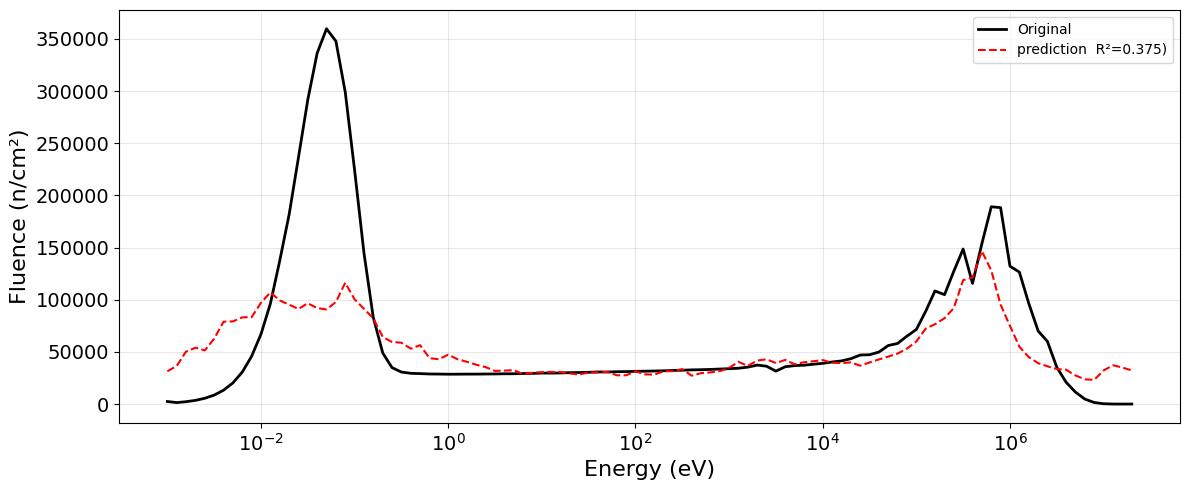

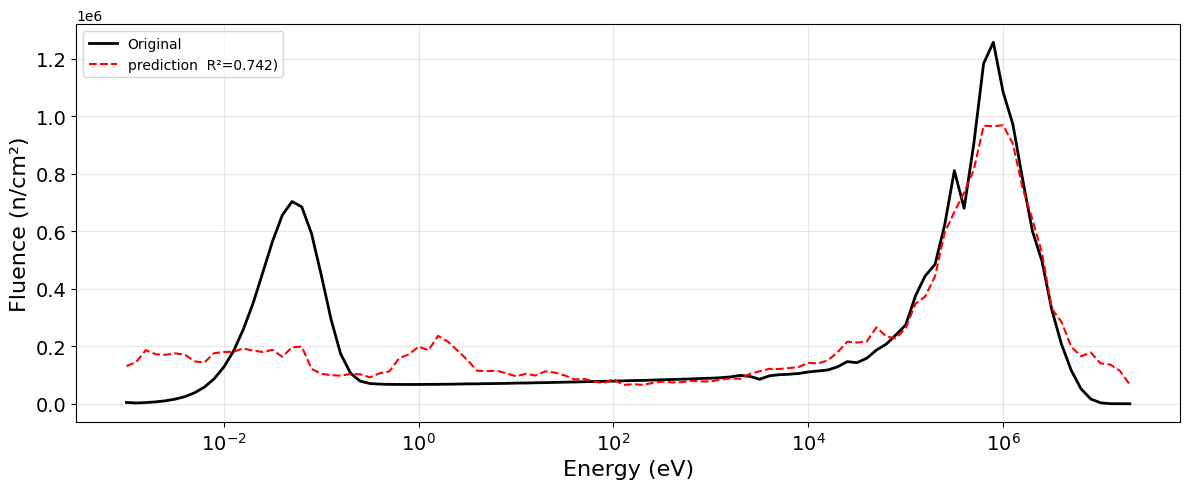

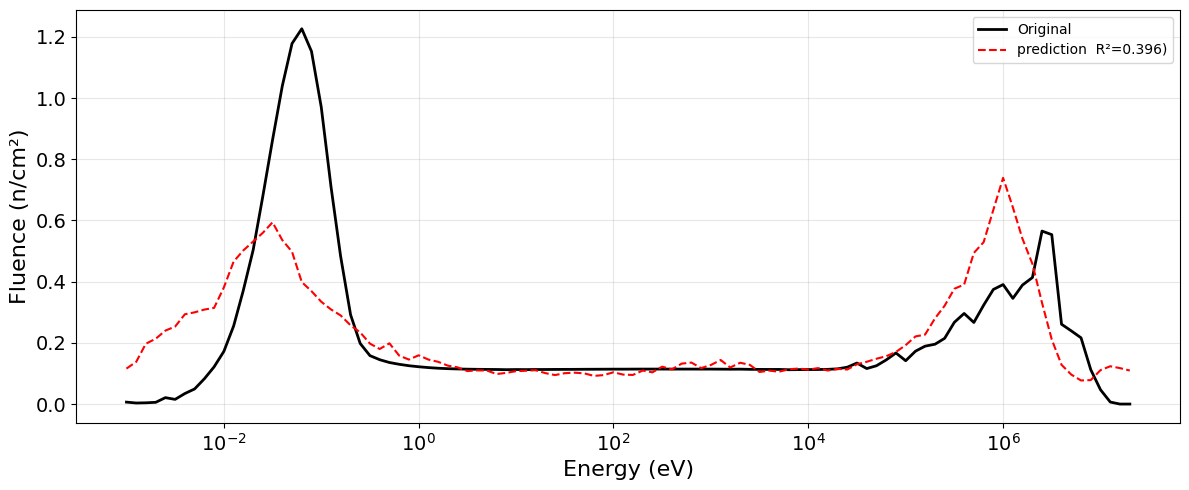

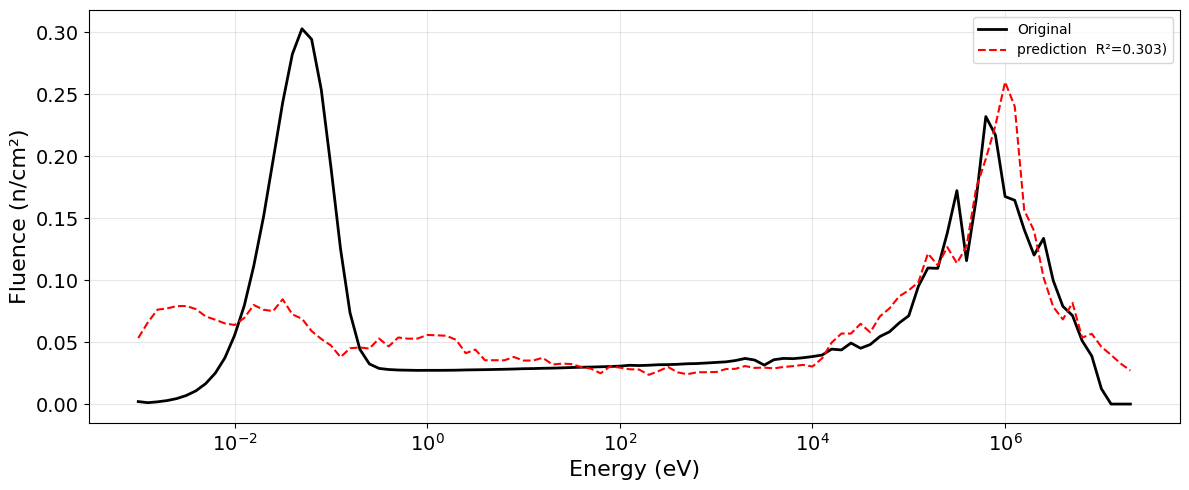

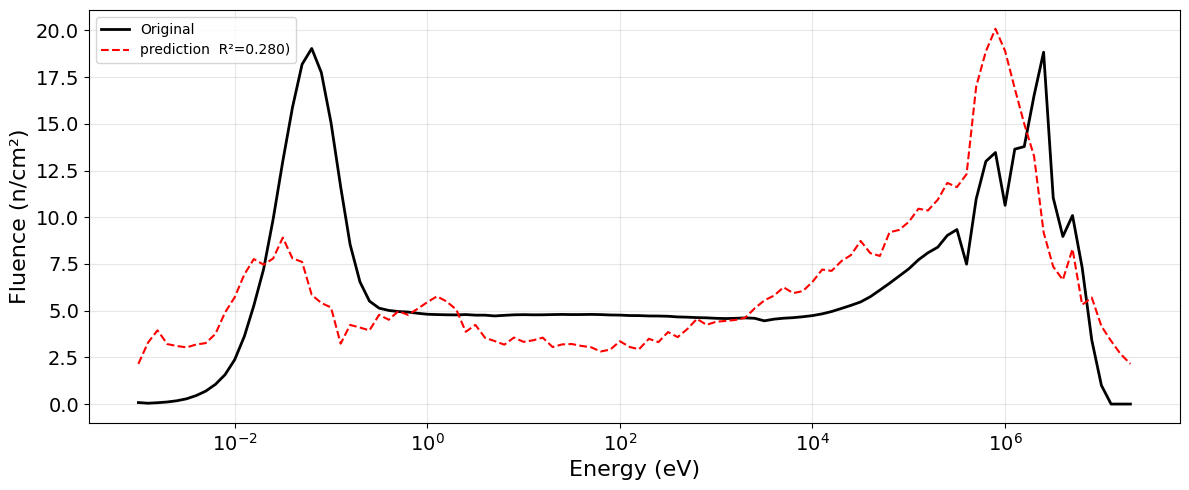

✅ Results saved to xgb_sums_results_augmented.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import find_peaks

# --------------------------
# 1) LOAD TRAINING DATA + REMOVE BAD IDS + NORMALIZE
# --------------------------
train_df = pd.read_csv("/content/Dataset_modified.csv")
spectrum_cols = [c for c in train_df.columns if c.startswith("spectrum_value_")]
count_cols = [c for c in train_df.columns if c.startswith("count_")]
train_df[spectrum_cols] = train_df[spectrum_cols].apply(pd.to_numeric, errors="coerce")

remove_ids = {5,6,7,8,13,14,15,16,17,18,19,20,21,22,23,24,
              48,49,51,52,53,54,55,56,57,58,
              68,70,74,75,77,78,79,81,82,
              86,89,90,91,92,96,97,98,99,100,
              102,106,107,108,110,111,112,113,114}
train_df = train_df[~train_df["spectrum_id"].isin(remove_ids)].copy()

# Normalize
train_counts_total = train_df[count_cols].sum(axis=1)
train_counts_total[train_counts_total == 0] = 1
train_spectrum_total = train_df[spectrum_cols].sum(axis=1)
train_spectrum_total[train_spectrum_total == 0] = 1
train_df[count_cols] = train_df[count_cols].div(train_counts_total, axis=0)
train_df[spectrum_cols] = train_df[spectrum_cols].div(train_spectrum_total, axis=0)

# --------------------------
# 2) DATA AUGMENTATION
# --------------------------
def add_gaussian_noise(spectrum, noise_level=0.05):
    noise = np.random.normal(0, noise_level * np.maximum(spectrum, 0.01), size=spectrum.shape)
    return np.clip(spectrum + noise, 0, None)

def multiplicative_noise(spectrum, scale_range=(0.95, 1.05)):
    return spectrum * np.random.uniform(*scale_range)

def smooth_spectrum(spectrum, window_size=5):
    kernel = np.ones(window_size) / window_size
    return np.convolve(spectrum, kernel, mode="same")

def random_peak_scaling(spectrum, prominence=0.05, scale_range=(0.8, 1.3)):
    peaks, _ = find_peaks(spectrum, prominence=prominence * np.max(spectrum))
    if len(peaks) == 0: return spectrum
    aug = spectrum.copy()
    selected_peaks = np.random.choice(peaks, size=np.random.randint(1, min(len(peaks), 3)+1), replace=False)
    for p in selected_peaks:
        scale = np.random.uniform(*scale_range)
        aug[p] *= scale
        if p > 0: aug[p-1] *= (scale+1)/2
        if p < len(aug)-1: aug[p+1] *= (scale+1)/2
    return np.clip(aug, 0, None)

def augment_sequentially(spectrum):
    aug = random_peak_scaling(spectrum)
    aug = smooth_spectrum(aug)
    aug = multiplicative_noise(aug)
    aug = add_gaussian_noise(aug)
    return np.clip(aug, 0, None)

def augment_training_data(train_df, n_augments=3):
    augmented_rows = []
    for _, row in train_df.iterrows():
        spectrum = row[spectrum_cols].values.astype(float)
        for _ in range(n_augments):
            augmented_row = row.copy()
            new_spectrum = augment_sequentially(spectrum)
            augmented_row[spectrum_cols] = new_spectrum
            augmented_rows.append(augmented_row)
    return pd.concat([train_df, pd.DataFrame(augmented_rows)], ignore_index=True)

print("🔧 Augmenting training data...")
train_aug = augment_training_data(train_df, n_augments=5)
print(f"✅ Training data augmented: {len(train_aug)} samples")

# Training arrays
X_train = train_aug[count_cols].values
Y_train = train_aug[spectrum_cols].values

# --------------------------
# 3) TRAIN XGBOOST MODELS
# --------------------------
def train_xgb_multioutput(X, Y):
    models = []
    for j in range(Y.shape[1]):
        model = XGBRegressor(
            n_estimators=300, max_depth=6, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            tree_method="hist", n_jobs=-1, verbosity=0, random_state=42
        )
        model.fit(X, Y[:, j])
        models.append(model)
    return models

def predict_xgb_multioutput(models, X):
    preds = [model.predict(X) for model in models]
    return np.column_stack(preds)

print("🔧 Training XGBoost...")
xgb_models = train_xgb_multioutput(X_train, Y_train)
print("✅ XGBoost trained successfully.")

# --------------------------
# 4) LOAD TEST DATA + NORMALIZE
# --------------------------
test_df = pd.read_csv("/content/Test_Dataset_modified.csv")
test_df[spectrum_cols] = test_df[spectrum_cols].apply(pd.to_numeric, errors="coerce")


test_counts_total = test_df[count_cols].sum(axis=1)
test_counts_total[test_counts_total == 0] = 1
test_spectrum_total = test_df[spectrum_cols].sum(axis=1)
test_spectrum_total[test_spectrum_total == 0] = 1
test_df[count_cols] = test_df[count_cols].div(test_counts_total, axis=0)
test_df[spectrum_cols] = test_df[spectrum_cols].div(test_spectrum_total, axis=0)

# --------------------------
# 5) ENERGY BINS + REGION MASKS
# --------------------------
energy_bins = np.array([
    0.001, 0.00126, 0.00158, 0.002, 0.00251, 0.00316, 0.00398, 0.00501, 0.00631, 0.00794,
    0.01, 0.0126, 0.0158, 0.02, 0.0251, 0.0316, 0.0398, 0.0501, 0.0631, 0.0794,
    0.1, 0.126, 0.158, 0.2, 0.251, 0.316, 0.398, 0.501, 0.631, 0.794,
    1, 1.26, 1.58, 2, 2.51, 3.16, 3.98, 5.01, 6.31, 7.94,
    10, 12.6, 15.8, 20, 25.1, 31.6, 39.8, 50.1, 63.1, 79.4,
    100, 126, 158, 200, 251, 316, 398, 501, 631, 794,
    1000, 1260, 1580, 2000, 2510, 3160, 3980, 5010, 6310, 7940,
    10000, 12600, 15800, 20000, 25100, 31600, 39800, 50100, 63100, 79400,
    100000, 126000, 158000, 200000, 251000, 316000, 398000, 501000, 631000, 794000,
    1000000, 1260000, 1580000, 2000000, 2510000, 3160000, 3980000, 5010000, 6310000, 7940000,
    10000000, 12600000, 15800000, 20000000
])

thermal_mask    = energy_bins < 0.4
epithermal_mask = (energy_bins >= 0.4) & (energy_bins < 1e5)
fast_mask       = energy_bins >= 1e5
total_mask      = np.ones(len(energy_bins), dtype=bool)

region_masks = {
    "thermal": thermal_mask,
    "epithermal": epithermal_mask,
    "fast": fast_mask,
    "total": total_mask,
}

# --------------------------
# 6) PREDICT + EVALUATE
# --------------------------
results = []

for idx, row in test_df.iterrows():
    x_test = row[count_cols].values.reshape(1, -1)
    y_true_norm = row[spectrum_cols].values
    y_pred_norm = predict_xgb_multioutput(xgb_models, x_test)[0]

    # Restore actual values
    spectrum_total = test_spectrum_total.iloc[idx]
    y_true_actual = y_true_norm * spectrum_total
    y_pred_actual = y_pred_norm * spectrum_total

    mse = mean_squared_error(y_true_actual, y_pred_actual)
    r2 = r2_score(y_true_actual, y_pred_actual)

    row_res = {"spectrum_id": row["spectrum_id"], "MSE": mse, "R2": r2}
    for region, mask in region_masks.items():
        phi_true_sum = np.sum(y_true_actual[mask])
        phi_pred_sum = np.sum(y_pred_actual[mask])
        rel_diff_sum = 100 * (phi_pred_sum - phi_true_sum) / (phi_true_sum if phi_true_sum != 0 else 1)

        row_res[f"{region}_sum_true"] = phi_true_sum
        row_res[f"{region}_sum_pred"] = phi_pred_sum
        row_res[f"{region}_sum_reldiff(%)"] = rel_diff_sum

    results.append(row_res)

    # Plot comparison
    plt.figure(figsize=(12, 5))
    plt.semilogx(energy_bins, y_true_actual, label="Original", color="black", linewidth=2)
    plt.semilogx(energy_bins, y_pred_actual, linestyle="--",
                 label=f"prediction  R²={r2:.3f})", color="red")
    plt.xlabel("Energy (eV)", fontsize=16)
    plt.ylabel("Fluence (n/cm²)", fontsize=16)
    plt.legend()
    plt.grid(alpha=0.3, which="both")
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

# --------------------------
# 7) SAVE RESULTS
# --------------------------
results_df = pd.DataFrame(results)
results_df.to_csv("xgb_sums_results_augmented.csv", index=False)
print("✅ Results saved to xgb_sums_results_augmented.csv")


#Model Performance After Collecting More Data

🔧 Training XGBoost (no augmentation)...
✅ Model trained successfully.
Number of spectrum bins = 104
thermal: 27 bins
epithermal: 53 bins
fast: 24 bins
total: 104 bins


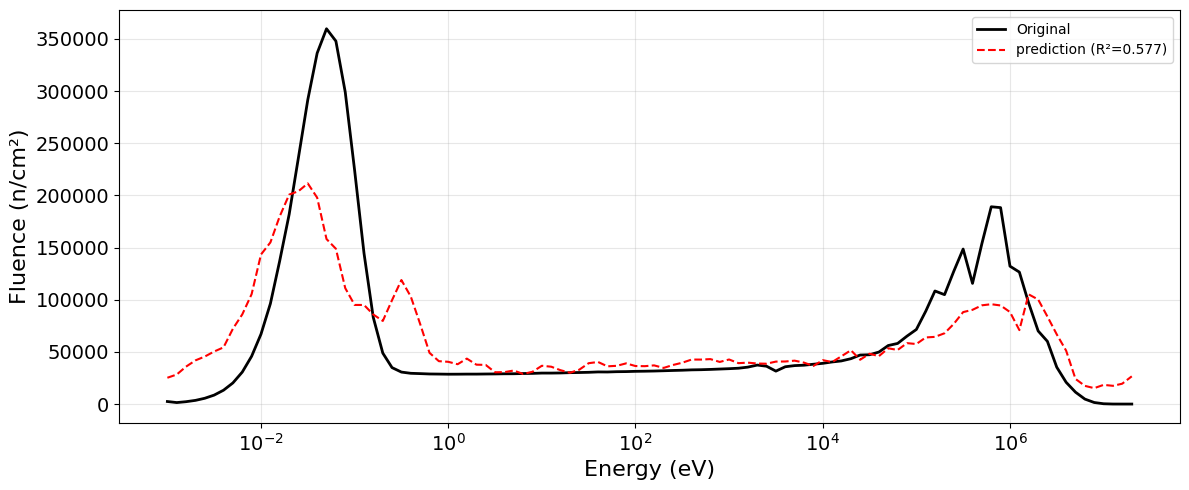

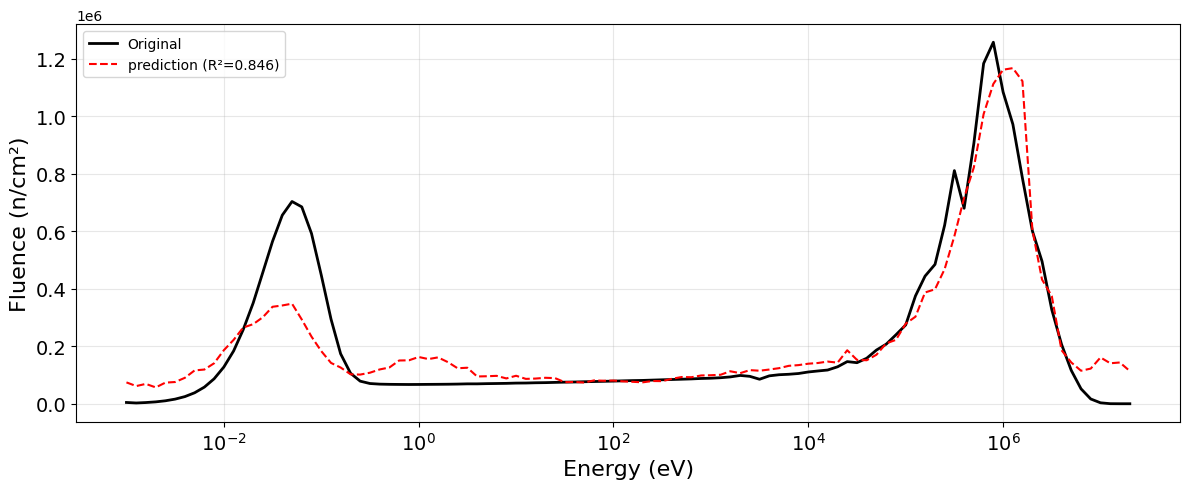

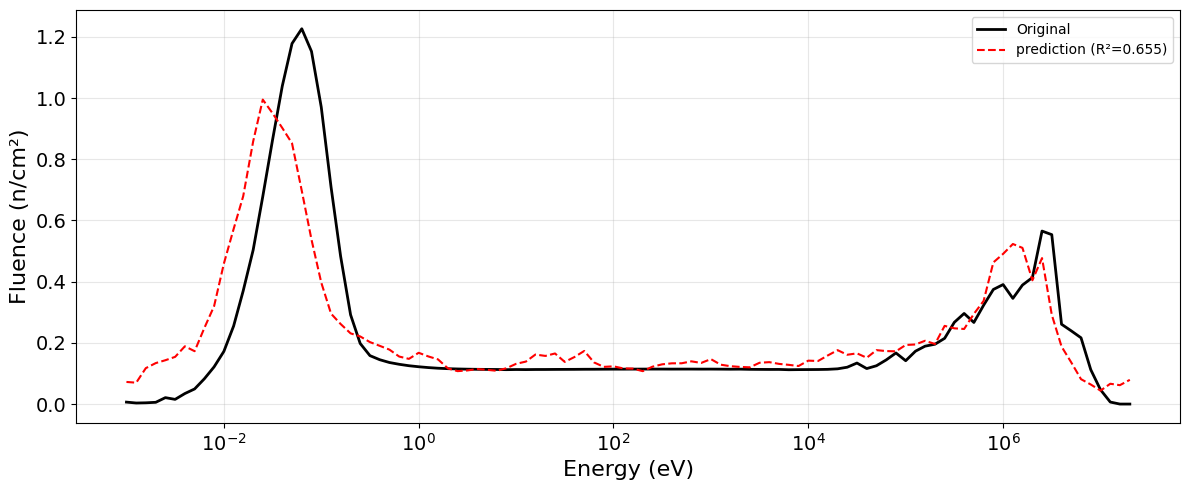

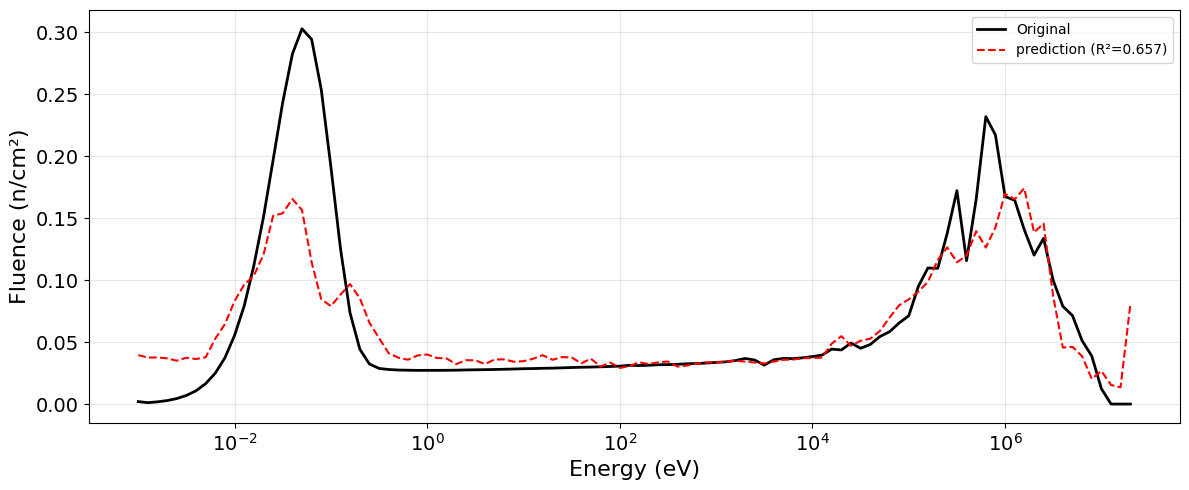

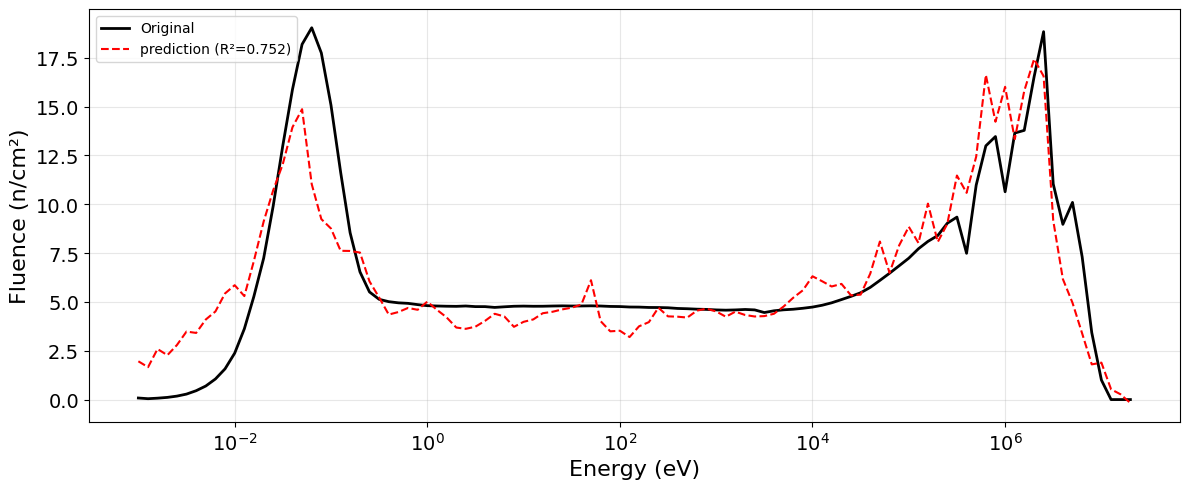

✅ Results saved to xgb_sums_results.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import  r2_score

# --------------------------
# 1) LOAD TRAINING DATA + NORMALIZE
# --------------------------
# Note: You'll need to replace the file paths with the actual location of your data.
try:
    train_df = pd.read_csv("complete_dataset.csv")
except FileNotFoundError:
    print("Error: 'complete_dataset.csv' not found. Please check the file path.")
    # Create dummy data to allow the script to run for demonstration
    print("Creating dummy training data...")
    num_samples_train = 100
    num_counts = 50
    num_spectrum = 104
    train_df = pd.DataFrame(np.random.rand(num_samples_train, num_counts + num_spectrum))
    train_df.columns = [f"count_{i}" for i in range(num_counts)] + [f"spectrum_value_{i}" for i in range(num_spectrum)]


spectrum_cols = [c for c in train_df.columns if c.startswith("spectrum_value_")]
count_cols = [c for c in train_df.columns if c.startswith("count_")]
train_df[spectrum_cols] = train_df[spectrum_cols].apply(pd.to_numeric, errors="coerce")

# Normalization
train_counts_total = train_df[count_cols].sum(axis=1)
train_counts_total[train_counts_total == 0] = 1
train_spectrum_total = train_df[spectrum_cols].sum(axis=1)
train_spectrum_total[train_spectrum_total == 0] = 1

train_df[count_cols] = train_df[count_cols].div(train_counts_total, axis=0)
train_df[spectrum_cols] = train_df[spectrum_cols].div(train_spectrum_total, axis=0)

X_train = train_df[count_cols].values
Y_train = train_df[spectrum_cols].values

# --------------------------
# 2) TRAIN MODEL (NO AUGMENTATION)
# --------------------------
def train_xgb_multioutput(X, Y):
    models = []
    for j in range(Y.shape[1]):
        model = XGBRegressor(
            n_estimators=300, max_depth=6, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            tree_method="hist", n_jobs=-1, verbosity=0
        )
        model.fit(X, Y[:, j])
        models.append(model)
    return models

def predict_xgb_multioutput(models, X):
    preds = [model.predict(X) for model in models]
    return np.column_stack(preds)

print("🔧 Training XGBoost (no augmentation)...")
xgb_models = train_xgb_multioutput(X_train, Y_train)
print("✅ Model trained successfully.")

# --------------------------
# 3) LOAD TEST DATA + NORMALIZE
# --------------------------
try:
    test_df = pd.read_csv("Test_Dataset_modified.csv")
except FileNotFoundError:
    print("Error: 'Test_Dataset_modified.csv' not found. Please check the file path.")
    # Create dummy data to allow the script to run for demonstration
    print("Creating dummy test data...")
    num_samples_test = 10
    test_df = pd.DataFrame(np.random.rand(num_samples_test, num_counts + num_spectrum + 1))
    test_df.columns = ["spectrum_id"] + [f"count_{i}" for i in range(num_counts)] + [f"spectrum_value_{i}" for i in range(num_spectrum)]
    test_df["spectrum_id"] = [f"test_{i}" for i in range(num_samples_test)]


test_df[spectrum_cols] = test_df[spectrum_cols].apply(pd.to_numeric, errors="coerce")

test_counts_total = test_df[count_cols].sum(axis=1)
test_counts_total[test_counts_total == 0] = 1
test_spectrum_total = test_df[spectrum_cols].sum(axis=1)
test_spectrum_total[test_spectrum_total == 0] = 1

test_df[count_cols] = test_df[count_cols].div(test_counts_total, axis=0)
test_df[spectrum_cols] = test_df[spectrum_cols].div(test_spectrum_total, axis=0)

# --------------------------
# 4) ENERGY BINS (CORRECTED)
# --------------------------
bin_edges = np.array([
    0.001, 0.00126, 0.00158, 0.002, 0.00251, 0.00316, 0.00398, 0.00501, 0.00631, 0.00794,
    0.01, 0.0126, 0.0158, 0.02, 0.0251, 0.0316, 0.0398, 0.0501, 0.0631, 0.0794,
    0.1, 0.126, 0.158, 0.2, 0.251, 0.316, 0.398, 0.501, 0.631, 0.794,
    1, 1.26, 1.58, 2, 2.51, 3.16, 3.98, 5.01, 6.31, 7.94,
    10, 12.6, 15.8, 20, 25.1, 31.6, 39.8, 50.1, 63.1, 79.4,
    100, 126, 158, 200, 251, 316, 398, 501, 631, 794,
    1000, 1260, 1580, 2000, 2510, 3160, 3980, 5010, 6310, 7940,
    10000, 12600, 15800, 20000, 25100, 31600, 39800, 50100, 63100, 79400,
    100000, 126000, 158000, 200000, 251000, 316000, 398000, 501000, 631000, 794000,
    1000000, 1260000, 1580000, 2000000, 2510000, 3160000, 3980000, 5010000, 6310000, 7940000,
    10000000, 12600000, 15800000, 20000000
])

# FIX 1: Correctly define n_bins. It should be the length of the energy points array.
n_bins = len(bin_edges) # This is 104, matching the number of spectrum columns.
print(f"Number of spectrum bins = {n_bins}")

# FIX 2: Define masks with length 104 by using the full `bin_edges` array.
thermal_mask    = bin_edges < 0.4
epithermal_mask = (bin_edges >= 0.4) & (bin_edges < 1e5)
fast_mask       = bin_edges >= 1e5
total_mask      = np.ones(n_bins, dtype=bool)

region_masks = {
    "thermal": thermal_mask,
    "epithermal": epithermal_mask,
    "fast": fast_mask,
    "total": total_mask,
}

# print region bin counts to confirm
for region, mask in region_masks.items():
    print(f"{region}: {np.sum(mask)} bins")


# --------------------------
# 5) PREDICT + EVALUATE (CORRECTED)
# --------------------------
results = []

for idx, row in test_df.iterrows():
    x_test = row[count_cols].values.reshape(1, -1)
    y_true_norm = row[spectrum_cols].values
    y_pred_norm = predict_xgb_multioutput(xgb_models, x_test)[0]

    # Restore actual values
    spectrum_total = test_spectrum_total.iloc[idx]
    y_true_actual = y_true_norm * spectrum_total
    y_pred_actual = y_pred_norm * spectrum_total


    r2 = r2_score(y_true_actual, y_pred_actual)

    # Compute sums in regions
    row_res = {"spectrum_id": row["spectrum_id"], "R2": r2}
    for region, mask in region_masks.items():
        # This will now work correctly as len(mask) == len(y_true_actual)
        phi_true_sum = np.sum(y_true_actual[mask])
        phi_pred_sum = np.sum(y_pred_actual[mask])
        rel_diff_sum = 100 * (phi_pred_sum - phi_true_sum) / (phi_true_sum if phi_true_sum != 0 else 1)

        row_res[f"{region}_sum_true"] = phi_true_sum
        row_res[f"{region}_sum_pred"] = phi_pred_sum
        row_res[f"{region}_sum_reldiff(%)"] = rel_diff_sum

    results.append(row_res)

    # Plot spectrum comparison
    plt.figure(figsize=(12, 5))
    # FIX 3: Use the full `bin_edges` array for plotting.
    plt.semilogx(bin_edges, y_true_actual, label="Original", color="black", linewidth=2)
    plt.semilogx(bin_edges, y_pred_actual, linestyle="--",
                 label=f"prediction (R²={r2:.3f})", color="red")

    plt.xlabel("Energy (eV)", fontsize=16)
    plt.ylabel("Fluence (n/cm²)", fontsize=16)
    plt.legend()
    plt.grid(alpha=0.3, which="both")
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.tight_layout()
    plt.show()

# --------------------------
# 6) SAVE RESULTS
# --------------------------
results_df = pd.DataFrame(results)
results_df.to_csv("xgb_sums_results.csv", index=False)
print("✅ Results saved to xgb_sums_results.csv")